# 1. Introuction

 This notebook outlines the creation, compilation, and training of a SWIN Transformer network to classify 101 types of food. Two models will be trained, a model for 101 classes and another one supporting an extra class called "unknown". This class was created using images from the [iFood-2019 dataset](https://www.kaggle.com/competitions/ifood-2019-fgvc6/data) that contains 251 food types. In the other trained models, PyTorch's pretrained weights will be used to initialize the models and no transfer learning will be applied. 

# 2. Importing Libraries

In [1]:
import os
import torch
import torchvision
import torch.backends.cudnn as cudnn
import numpy as np
import pandas as pd

from torch import nn
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torchvision import datasets
from torch.optim.lr_scheduler import CosineAnnealingLR
#from warmup_scheduler_pytorch import WarmUpScheduler
#from timm.scheduler.cosine_lr import CosineLRScheduler

# Import custom libraries
from modules.helper_functions import set_seeds, display_random_images
from modules.engine import Trainer, sec_to_min_sec
from modules.scheduler import FixedLRSchedulerWrapper
from modules.dataloaders import create_dataloaders
#from modules.scheduler import WarmupCosineAnnealingLR

# Define some constants
NUM_WORKERS = os.cpu_count()
AMOUNT_TO_GET = 1.0
SEED = 42

# Define target data directory
TARGET_DIR_NAME = f"../data/food-101_{str(int(AMOUNT_TO_GET*100))}_percent"

# Setup training and test directories
TARGET_DIR = Path(TARGET_DIR_NAME)
TRAIN_DIR = TARGET_DIR / "train"
TEST_DIR = TARGET_DIR / "test"
TARGET_DIR.mkdir(parents=True, exist_ok=True)

# Create target model directory
MODEL_DIR = Path("../models")

# Set seeds
set_seeds(SEED)

# 3. Specifying Target Device

In [2]:
# Activate cuda benchmark
cudnn.benchmark = True

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if device == "cuda":
    !nvidia-smi

Device: cuda
Sat Jan 18 22:18:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070      WDDM  |   00000000:01:00.0  On |                  N/A |
| 30%   46C    P8             12W /  200W |    1439MiB /  12282MiB |     11%      Default |
|                                         |                        |                  N/A |
+----------------------------------

# 4. Image Visualization

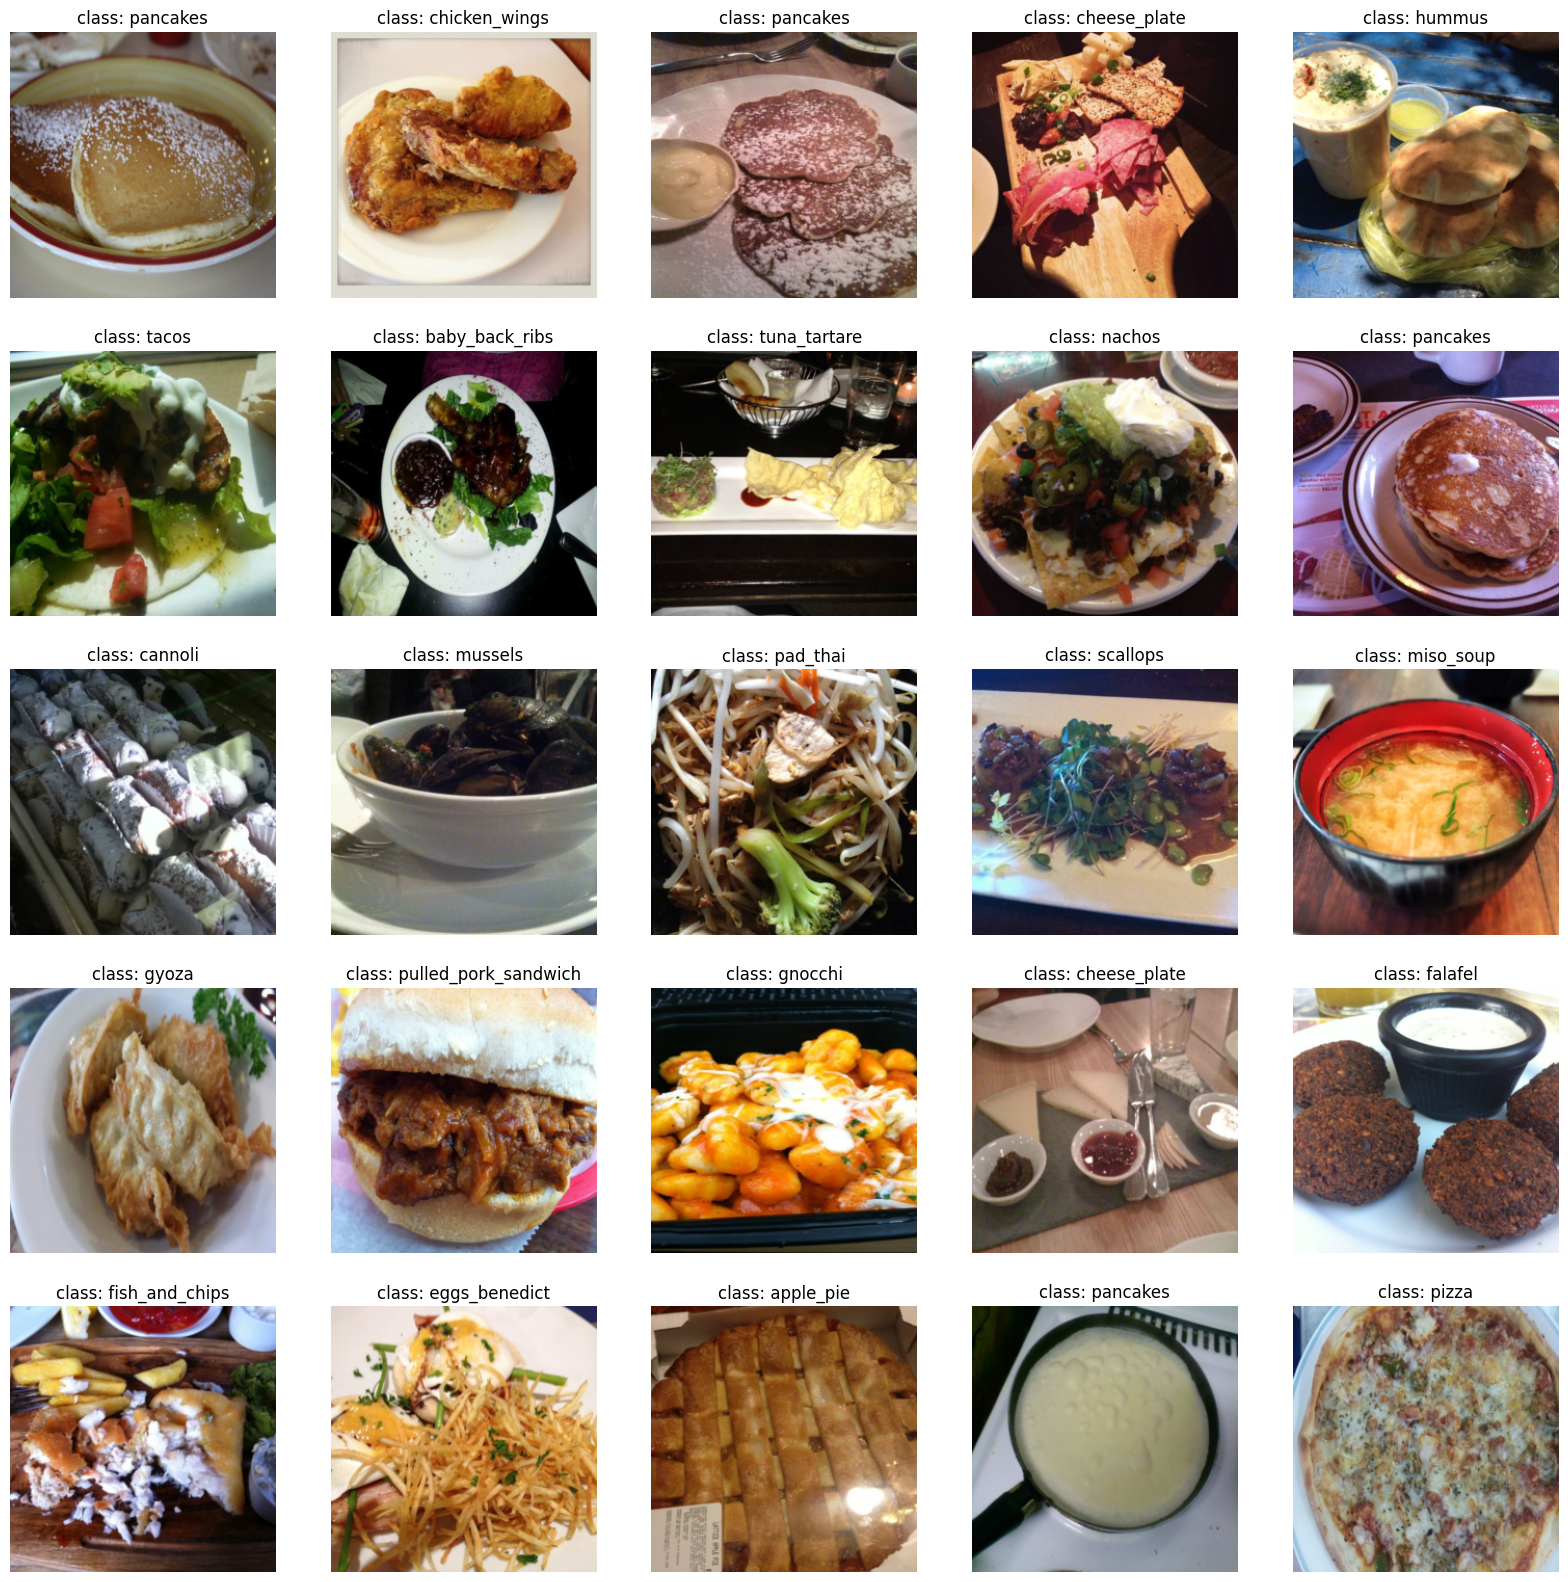

In [3]:
# Display images
manual_transforms = v2.Compose([
    v2.Resize((256, 256)),
    v2.RandomCrop((256, 256)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True)
])

train_data = datasets.ImageFolder(TRAIN_DIR, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=train_data.classes,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 5. Default PyTorch's ViT-Base/16-224

In [4]:
# Create transforms
IMG_SIZE_1 = 256
IMG_SIZE_2 = 224
manual_transforms_train = v2.Compose([    
    v2.TrivialAugmentWide(),
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.RandomCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

manual_transforms_test = v2.Compose([    
    v2.Resize((IMG_SIZE_1, IMG_SIZE_1)),
    v2.CenterCrop((IMG_SIZE_2, IMG_SIZE_2)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]) 
    ])

# Create dataloaders
BATCH_SIZE = 64
train_dataloader, test_dataloader, class_names = create_dataloaders(    
    train_dir=TRAIN_DIR,
    test_dir=TEST_DIR,
    train_transform=manual_transforms_train,
    test_transform=manual_transforms_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS
)

# Copy weights from torchvision.models
set_seeds(SEED)

# Instantiate the model
model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT).to(device)

model.heads = nn.Linear(in_features=768, out_features=len(class_names)).to(device)

# Unfreeze the base parameters
for parameter in model.parameters():
    parameter.requires_grad = True

# Compile model
model = torch.compile(model, backend="aot_eager")

c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.Op.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()
c:\Users\ssre_\.conda\envs\.venv_pytorch_gpu\Lib\site-packages\onnxscript\converter.py:820: FutureWarning: 'onnxscript.values.OnnxFunction.param_schemas' is deprecated in version 0.1 and will be removed in the future. Please use '.op_signature' instead.
  param_schemas = callee.param_schemas()


In [ ]:
# Train the model
model_type="vitb224_101_2025-01-18"
EPOCHS = 10
LR = 0.0001
model_name = f"{model_type}"
model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"], # Based on accuracy
    device=device)

results = train.fit(
    target_dir=MODEL_DIR,
    model_name=model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=1,
    )

In [ ]:
results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0      1    2.041897   0.642894             0.114982     2330.527193   
1      2    1.510450   0.787302             0.026759     2271.655912   
2      3    1.366547   0.828383             0.015279     2286.242224   
3      4    1.271639   0.856054             0.009707     2312.965180   
4      5    1.191092   0.878885             0.006163     2279.843962   
5      6    1.125374   0.899498             0.003912     2333.301921   
6      7    1.069926   0.916658             0.002497     2342.706653   
7      8    1.031505   0.929527             0.001649     2317.135618   
8      9    1.003434   0.938503             0.001233     2341.246624   
9     10    0.986894   0.944892             0.000960     2321.385335   

   test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0   1.330157  0.848876            0.008629     361.311990  0.000100  
1   1.200258  0.876148            0.005236     329.092049  0.000098  
2   1.147945  0.891545            0.004541     333.511352  0.000091  
3   1.127565  0.896414            0.004394     333.702853  0.000080  
4   1.095416  0.902035            0.003844     327.879499  0.000066  
5   1.076820  0.908447            0.003301     352.513170  0.000051  
6   1.055183  0.913949            0.002811     339.093357  0.000035  
7   1.045623  0.916838            0.002560     336.147734  0.000021  
8   1.041611  0.919055            0.002433     336.582034  0.000010  
9   1.037223  0.919767            0.002413     336.133252  0.000003

Epoch: 20 | train_loss: 0.8461 | train_acc: 0.9823 | fpr_at_recall: 0.0000 | train_time: 6m8s | test_loss: 1.1962 | test_acc: 0.8806 | fpr_at_recall: 0.0103 | test_time: 1m28s | lr: 0.0000016094


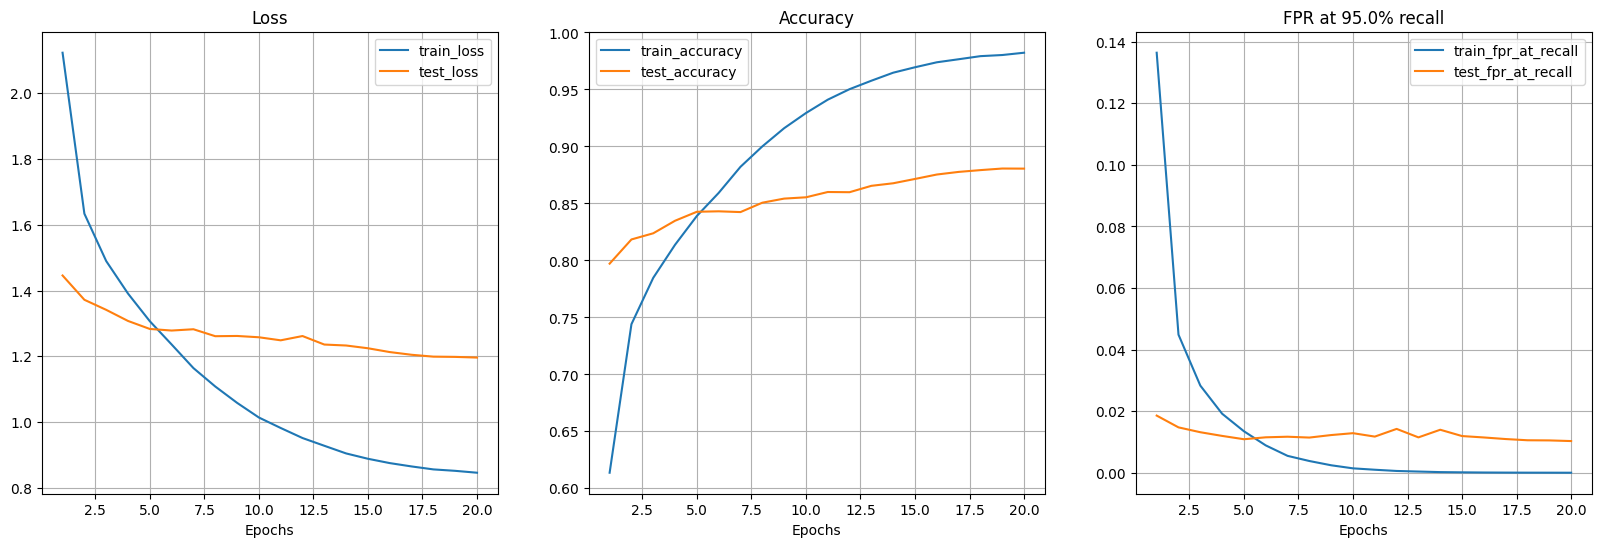

[INFO] Saving model to: ..\models\vitb224_101_2025-01-19_loss.pth
[INFO] Saving model to: ..\models\vitb224_101_2025-01-19.pth


In [5]:
# Train the model
model_type="vitb224_101_2025-01-19"
EPOCHS = 20
LR = 0.0001
model_name = f"{model_type}"
swinb_model_name = model_name + ".pth"

# Create optimizer
optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=LR,
    betas=(0.9, 0.999),
    weight_decay=0.01
)

# Create loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)

# Set scheduler
scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)

# Set seeds
set_seeds(SEED)

# And train...
train = Trainer(
    model=model,
    save_best_model=True,
    mode=["loss", "acc"],
    device=device)

results = train.fit(
    target_dir=MODEL_DIR,
    model_name=swinb_model_name,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    recall_threshold=0.95,
    scheduler=scheduler,
    epochs=EPOCHS,
    amp=True,
    enable_clipping=False,
    debug_mode=False,
    accumulation_steps=1,
    )

In [6]:
results

epoch  train_loss  train_acc  train_fpr_at_recall  train_time [s]  \
0       1    2.122983   0.613727             0.136384      383.829627   
1       2    1.633621   0.744045             0.044845      362.974903   
2       3    1.489627   0.784745             0.028320      360.711061   
3       4    1.390771   0.813761             0.019182      361.569962   
4       5    1.306680   0.839037             0.013487      361.606075   
5       6    1.235968   0.859263             0.008902      361.495338   
6       7    1.164168   0.882160             0.005504      363.932393   
7       8    1.108253   0.900038             0.003832      364.143596   
8       9    1.058583   0.916011             0.002445      361.298525   
9      10    1.013956   0.929313             0.001450      361.476913   
10     11    0.982097   0.941045             0.000999      361.719091   
11     12    0.951585   0.950274             0.000600      361.058143   
12     13    0.928035   0.957690             0.000411      361.999512   
13     14    0.904730   0.964729             0.000229      364.965069   
14     15    0.888495   0.969493             0.000154      361.533673   
15     16    0.875358   0.973857             0.000098      366.921285   
16     17    0.865194   0.976523             0.000069      368.628140   
17     18    0.856185   0.979241             0.000050      369.676828   
18     19    0.851839   0.980231             0.000042      375.981064   
19     20    0.846095   0.982250             0.000029      368.084092   

    test_loss  test_acc  test_fpr_at_recall  test_time [s]        lr  
0    1.445712  0.797180            0.018578      96.554765  0.000100  
1    1.371882  0.818408            0.014751      86.627825  0.000099  
2    1.341286  0.823816            0.013176      86.566779  0.000098  
3    1.307519  0.834829            0.011981      86.442885  0.000095  
4    1.283175  0.842705            0.010903      86.325635  0.000091  
5    1.278353  0.843096            0.011525      86.191808  0.000086  
6    1.282285  0.842428            0.011716      88.384233  0.000080  
7    1.261147  0.850656            0.011442      86.739660  0.000073  
8    1.261865  0.854251            0.012257      87.014625  0.000066  
9    1.257903  0.855394            0.012866      86.306101  0.000058  
10   1.248639  0.860036            0.011758      86.430841  0.000051  
11   1.261644  0.859868            0.014254      87.074620  0.000043  
12   1.235773  0.865460            0.011505      87.370085  0.000035  
13   1.232870  0.867701            0.013983      88.360890  0.000028  
14   1.224483  0.871493            0.011931      86.444909  0.000021  
15   1.212908  0.875375            0.011476      91.202432  0.000015  
16   1.204679  0.877674            0.010962      87.565939  0.000010  
17   1.198989  0.879251            0.010568      91.511821  0.000006  
18   1.198228  0.880636            0.010519      87.920020  0.000003  
19   1.196183  0.880557            0.010308      88.420939  0.000002

In [3]:
results = pd.read_csv(os.path.join(MODEL_DIR, "vitb224_101_2025-01-19.csv"))

In [4]:
training_time = sec_to_min_sec(results["train_time [s]"].mean() + results["test_time [s]"].mean())
print(f"training time: {training_time}")

training time: 7m33s
